In [35]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [45]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,21880,None,None,88580.656759
2020-06-13,21881,None,None,81831.239392
2020-06-14,21882,None,None,75613.445958
2020-06-15,21883,None,None,69927.931785
2020-06-16,21884,None,None,64949.954567
...,...,...,...,...
2021-01-01,22083,None,None,648066.587667
2021-01-02,22084,None,None,677219.635542
2021-01-03,22085,None,None,705963.894131


In [46]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-05_2021-01-05-16-55.pickle


In [47]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-04_2021-01-04-17-01.pickle


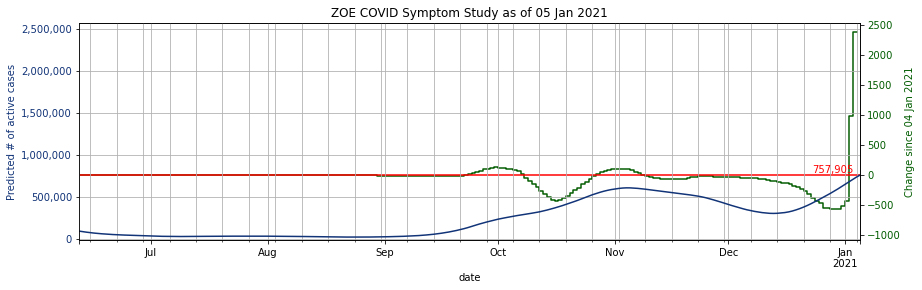

In [48]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

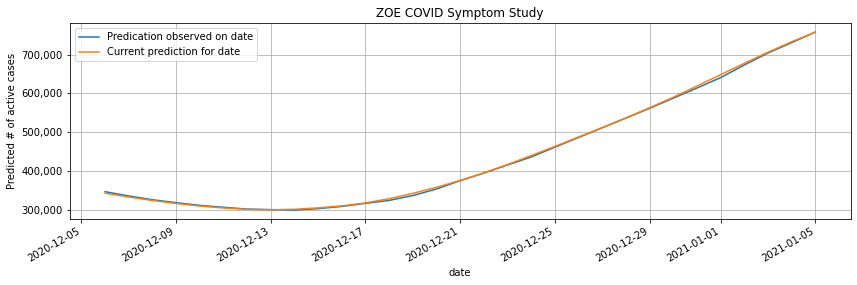

In [49]:
plot_study_evolution(curr_date, days=30)

In [50]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [51]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-01-05_2021-01-05-16-55.pickle


In [52]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
342,Bridgend,W06000013,7.237086
345,Enfield,E09000010,4.059619
330,Brent,E09000005,3.690674
384,Torfaen,W06000020,3.396381
343,Vale of Glamorgan,W06000014,3.341348
338,Croydon,E09000008,3.180293
361,Lambeth,E09000022,3.140953
333,Flintshire,W06000005,3.038875
334,Wrexham,W06000006,3.030885
331,Bromley,E09000006,2.842546
